In [2]:
import requests, pandas as pd, numpy as np
from pandas import Series, DataFrame, Panel
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [3]:
data_loaded = pd.read_pickle("mumbai_6.pkl")
data_loaded_np = data_loaded[["PM2.5","WS","RH","BP","VWS","SR","WD","TEMP"]].as_matrix()

In [4]:
data_loaded_np[0:,0]

array([ 64.31,  82.22,  81.38, ...,  28.52,  29.26,  21.68])

In [5]:
def to_timeseries(df,fromtime,totime,freq):
    dates = pd.date_range(fromtime, totime, freq=freq)
    df_np = df.as_matrix()
    df_ts = Series(df_np[:,3], index=dates)
    df_ts = DataFrame({'pm2.5' : df_ts})
    df_ts = df_ts.astype(float)
    return df_ts

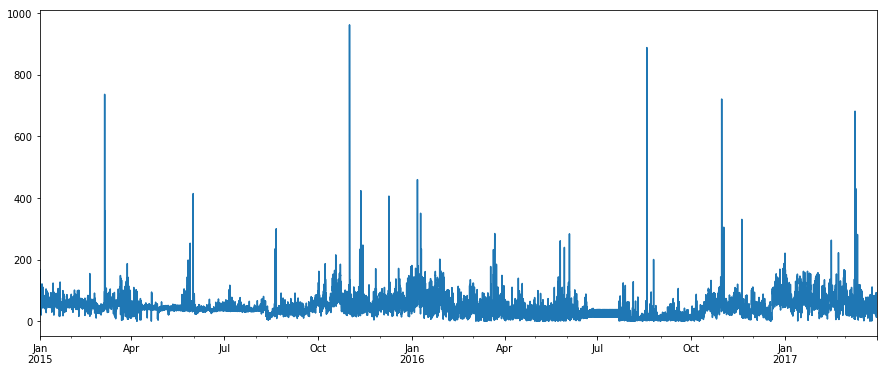

In [6]:
data_loaded_ts = to_timeseries(data_loaded,'2015-01-01 00:00:00','2017-03-31 23:00:00','H')
data_loaded_ts['pm2.5'].plot()

In [7]:
data_loaded_ts_week = data_loaded_ts.resample('1D').mean()

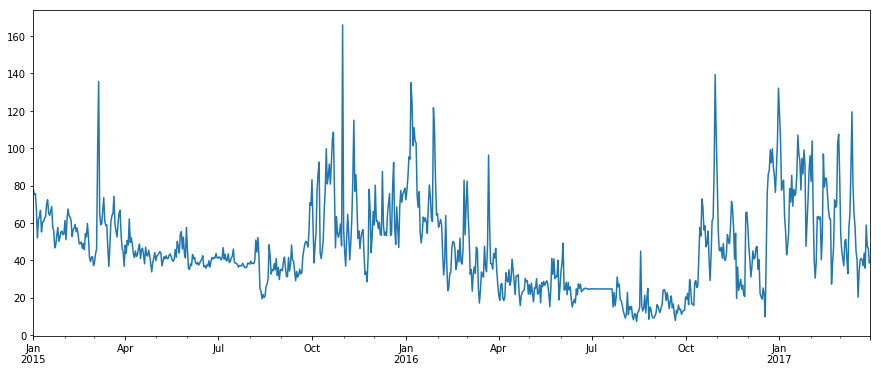

In [8]:
data_loaded_ts_week['pm2.5'].plot()

In [9]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

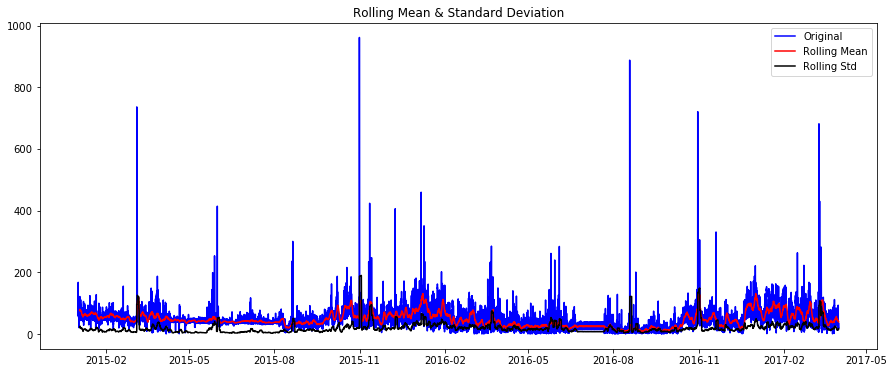

Results of Dickey-Fuller Test:
Test Statistic                -7.737574e+00
p-value                        1.083347e-11
#Lags Used                     4.500000e+01
Number of Observations Used    1.965800e+04
Critical Value (1%)           -3.430683e+00
Critical Value (10%)          -2.566848e+00
Critical Value (5%)           -2.861687e+00
dtype: float64


In [10]:
test_stationarity(data_loaded_ts['pm2.5'])

In [11]:
data_loaded_ts['pm2.5']

2015-01-01 00:00:00     64.31
2015-01-01 01:00:00     82.22
2015-01-01 02:00:00     81.38
2015-01-01 03:00:00     74.56
2015-01-01 04:00:00     70.49
2015-01-01 05:00:00     65.95
2015-01-01 06:00:00     77.63
2015-01-01 07:00:00     71.01
2015-01-01 08:00:00     67.88
2015-01-01 09:00:00     75.69
2015-01-01 10:00:00     72.61
2015-01-01 11:00:00    164.40
2015-01-01 12:00:00    167.37
2015-01-01 13:00:00     73.90
2015-01-01 14:00:00     58.99
2015-01-01 15:00:00     92.19
2015-01-01 16:00:00     82.01
2015-01-01 17:00:00     64.90
2015-01-01 18:00:00     58.58
2015-01-01 19:00:00     55.38
2015-01-01 20:00:00     58.10
2015-01-01 21:00:00     55.67
2015-01-01 22:00:00     55.32
2015-01-01 23:00:00     77.79
2015-01-02 00:00:00     91.82
2015-01-02 01:00:00     94.98
2015-01-02 02:00:00     90.05
2015-01-02 03:00:00     88.91
2015-01-02 04:00:00     87.54
2015-01-02 05:00:00     80.09
                        ...  
2017-03-30 18:00:00     34.50
2017-03-30 19:00:00     31.00
2017-03-30

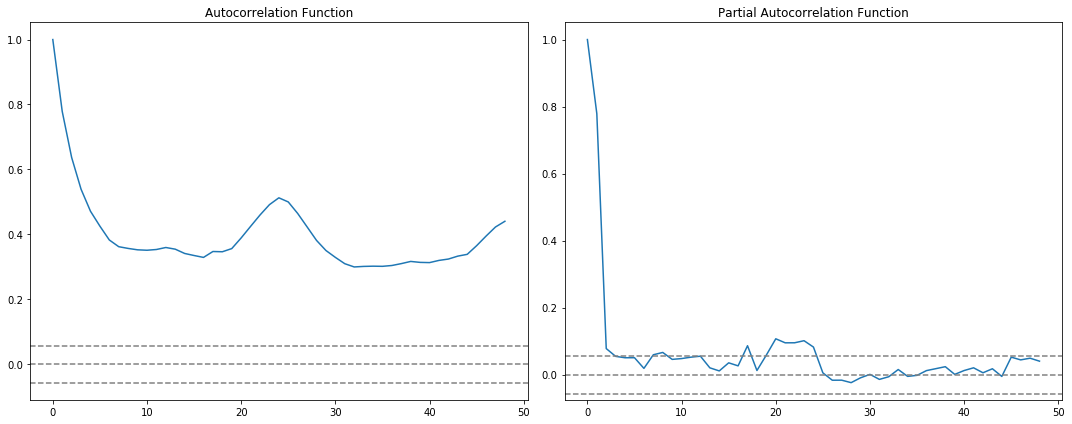

In [39]:
#ACF and PACF plots

lag_acf = acf(data_loaded_ts['pm2.5'], nlags=48)
lag_pacf = pacf(data_loaded_ts['pm2.5'], nlags=48, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(data_loaded_ts['pm2.5'])),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(data_loaded_ts['pm2.5'])),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(data_loaded_ts['pm2.5'])),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(data_loaded_ts['pm2.5'])),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

C:\Users\Razer\AppData\Local\conda\conda\envs\arima\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


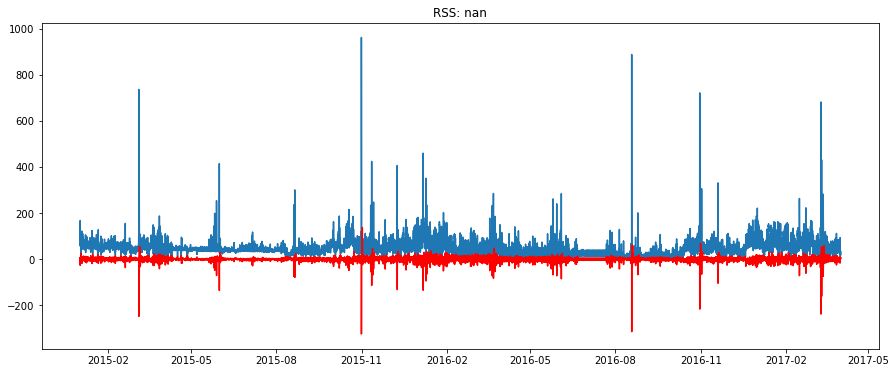

In [58]:
model = ARIMA(data_loaded_ts['pm2.5'], order=(24, 1, 8))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(data_loaded_ts['pm2.5'])
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-data_loaded_ts['pm2.5'])**2))

                             ARIMA Model Results                              
Dep. Variable:                D.pm2.5   No. Observations:                19703
Model:                ARIMA(24, 1, 8)   Log Likelihood              -87619.541
Method:                       css-mle   S.D. of innovations             20.656
Date:                Mon, 23 Oct 2017   AIC                         175307.083
Time:                        12:47:47   BIC                         175575.293
Sample:                    01-01-2015   HQIC                        175394.896
                         - 03-31-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0011      0.004     -0.261      0.794      -0.009       0.007
ar.L1.D.pm2.5      1.1410      0.129      8.856      0.000       0.888       1.394
ar.L2.D.pm2.5     -1.0838      0.229

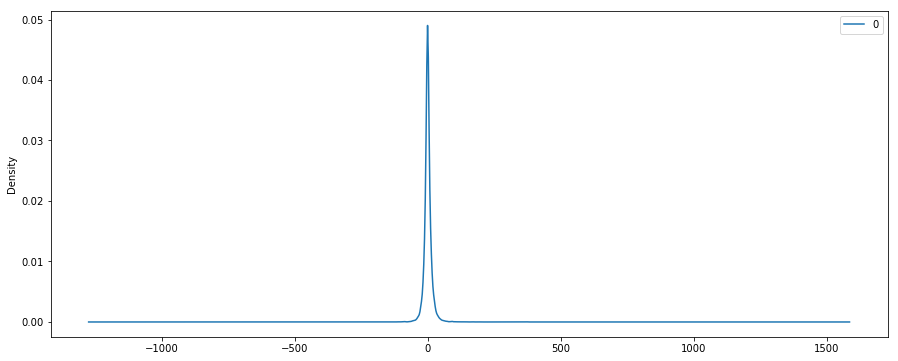

In [59]:
print(results_ARIMA.summary())
# plot residual errors
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

In [60]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

2015-01-01 01:00:00   -0.001068
2015-01-01 02:00:00   -3.218015
2015-01-01 03:00:00   -2.267508
2015-01-01 04:00:00   -0.488500
2015-01-01 05:00:00    0.338698
Freq: H, dtype: float64


In [61]:
# predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA = pd.Series(data_loaded_ts['pm2.5'].ix[0], index=data_loaded_ts['pm2.5'].index)
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff,fill_value=0)

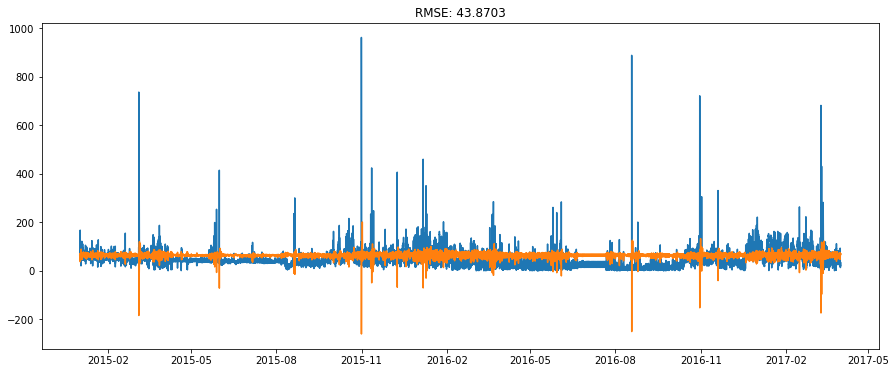

In [62]:
# predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(data_loaded_ts['pm2.5'])
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-data_loaded_ts['pm2.5'])**2)/len(data_loaded_ts['pm2.5'])))